In [1]:
import os
os.chdir('/Users/gpiren/Library/CloudStorage/Dropbox/Mac (2)/Desktop/Projects/Finance/NVIDIA exercise')

In [2]:

os.getcwd()

'/Users/gpiren/Library/CloudStorage/Dropbox/Mac (2)/Desktop/Projects/Finance/NVIDIA exercise'

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

In [13]:
# First, let's fetch the page of NVIDIA's most recent earnings call from February 2026

URL = "https://www.fool.com/earnings/call-transcripts/2026/02/25/nvidia-nvda-q4-2026-earnings-call-transcript/"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(URL, headers=headers)
response.raise_for_status()

# parsing the HTML

soup = BeautifulSoup(response.text, "html.parser")

transcript_section = soup.find("h2", string=lambda t: t and "Full Conference Call Transcript" in t)

In [14]:
# helper function to validate speaker labels

def is_speaker_label(text):
    text = text.strip().rstrip(":")
    words = text.split()
    return (
        len(words) > 0 and
        all(word[0].isupper() for word in words)
    )

In [15]:
# extracting speaker turns

turns = []
for p in transcript_section.find_all_next("p"):
    strong = p.find("strong")
    if strong and strong.text.strip().endswith(":") and is_speaker_label(strong.text):
        speaker = strong.text.strip().rstrip(":")
        text = p.get_text(separator=" ").replace(strong.text, "").strip()
        if text:
            turns.append({"speaker": speaker, "text": text})
    else:
        orphan_text = p.get_text(separator=" ").strip()
        if orphan_text and turns:
            turns[-1]["text"] += " " + orphan_text

In [16]:
# the dataframe
df = pd.DataFrame(turns)
df["turn_id"] = df.index

In [17]:
# creating the section labels. 'prepared Remarks vs Q&A'
qa_start_idx = df[df["text"].str.contains("open for questions", case=False, na=False)].index
qa_start = qa_start_idx[0] if len(qa_start_idx) > 0 else len(df)

df["section"] = "Prepared Remarks"
df.loc[df["turn_id"] > qa_start, "section"] = "Q&A"

In [18]:
# labeling the turn types

analyst_names = ["Vivek Arya", "Stacy Rasgon", "Atif Malik", "Ben Reitzes",
                 "Antoine Chiketan", "Mark Zapakos", "Aaron Rakers",
                 "Tim Arcuri", "Jim Schneider"]

def label_role(speaker):
    if speaker in ["Jensen Huang", "Colette Kress"]:
        return "management"
    elif speaker == "Toshiya Hari":
        return "IR"
    elif speaker in analyst_names:
        return "analyst"
    else:
        return "operator"

df["role"] = df["speaker"].apply(label_role)

print(df.shape)
print(df[["turn_id", "speaker", "role", "section"]].head(15))
print("\nSection counts:\n", df["section"].value_counts())
print("\nRole counts:\n", df["role"].value_counts())

(34, 5)
    turn_id        speaker        role           section
0         0   Toshiya Hari          IR  Prepared Remarks
1         1  Colette Kress  management  Prepared Remarks
2         2   Toshiya Hari          IR  Prepared Remarks
3         3   Jensen Huang  management  Prepared Remarks
4         4   Toshiya Hari          IR  Prepared Remarks
5         5          Sarah    operator               Q&A
6         6     Vivek Arya     analyst               Q&A
7         7   Jensen Huang  management               Q&A
8         8          Sarah    operator               Q&A
9         9   Stacy Rasgon     analyst               Q&A
10       10  Colette Kress  management               Q&A
11       11          Sarah    operator               Q&A
12       12     Atif Malik     analyst               Q&A
13       13   Jensen Huang  management               Q&A
14       14          Sarah    operator               Q&A

Section counts:
 section
Q&A                 29
Prepared Remarks     5
Name: co

In [19]:
df

,speaker,text,turn_id,section,role
0,Toshiya Hari,"Good afternoon, everyone, and welcome to NVIDI...",0,Prepared Remarks,IR
1,Colette Kress,"Thanks, Toshiya. We delivered another outstand...",1,Prepared Remarks,management
2,Toshiya Hari,"This quarter, we significantly deepened and ex...",2,Prepared Remarks,IR
3,Jensen Huang,We recently celebrated OpenAI's launch of GPT-...,3,Prepared Remarks,management
4,Toshiya Hari,"We will now open for questions. Operator, plea...",4,Prepared Remarks,IR
5,Sarah,"At this time, I would like to remind everyone,...",5,Q&A,operator
6,Vivek Arya,Thanks for taking my question. I think you men...,6,Q&A,analyst
7,Jensen Huang,I am confident in their cash flow growing. And...,7,Q&A,management
8,Sarah,The next question comes from Stacy Rasgon.,8,Q&A,operator
9,Stacy Rasgon,Thanks for taking my questions.,9,Q&A,analyst


### Some basic statistics - EDA

#### Summary statistics key takeaways

- Management dominates. Colette and Jensen together account for ~79% of all words spoken

- Analysts barely speak: average 73 words per turn vs. management's 451; they ask short questions, management gives long answers

- Q&A is actually longer than Prepared Remarks (4,231 vs 2,500 words) — driven by Jensen's lengthy Q&A responses

- Management expands in Q&A — their average turn drops from 1,129 words (prepared) to 316 (Q&A), but they still vastly outtalk everyone

- Stacy Rasgon said only 5 words. It was worth checking, I initially thought that it was likely a parsing issue, but the transcript does not include her question

In [20]:
# Let's explore the basic text statistics

df["word_count"] = df["text"].apply(lambda x: len(x.split()))
df["sentence_count"] = df["text"].apply(lambda x: len(re.split(r'[.!?]+', x.strip())))
df["avg_sentence_length"] = df["word_count"] / df["sentence_count"]

# words per speaker
words_by_speaker = df.groupby("speaker")["word_count"].sum().sort_values(ascending=False)
print("=== Total words by speaker ===")
print(words_by_speaker)

# words by roles
words_by_role = df.groupby("role")["word_count"].sum().sort_values(ascending=False)
print("\n=== Total words by role ===")
print(words_by_role)

# words by section
words_by_section = df.groupby("section")["word_count"].sum()
print("\n=== Total words by section ===")
print(words_by_section)

# average turn length by role
avg_turn_by_role = df.groupby("role")["word_count"].mean().sort_values(ascending=False)
print("\n=== Average words per turn by role ===")
print(avg_turn_by_role.round(1))

# for the summary table

summary = df.groupby(["role", "section"])["word_count"].agg(["sum", "mean", "count"])
summary.columns = ["total_words", "avg_words_per_turn", "num_turns"]
print("\n=== Full summary table ===")
print(summary.round(1))

=== Total words by speaker ===
speaker
Colette Kress       2766
Jensen Huang        2650
Toshiya Hari         351
Sarah                311
Vivek Arya           137
Tim Arcuri           110
Mark Zapakos          87
Ben Reitzes           80
Jim Schneider         79
Aaron Rakers          76
Antoine Chiketan      51
Atif Malik            28
Stacy Rasgon           5
Name: word_count, dtype: int64

=== Total words by role ===
role
management    5416
analyst        653
IR             351
operator       311
Name: word_count, dtype: int64

=== Total words by section ===
section
Prepared Remarks    2500
Q&A                 4231
Name: word_count, dtype: int64

=== Average words per turn by role ===
role
management    451.3
analyst        72.6
operator       51.8
IR             50.1
Name: word_count, dtype: float64

=== Full summary table ===
                             total_words  avg_words_per_turn  num_turns
role       section                                                     
IR         Pr

### Sophisticated insights

Let's try to understand what really happened during the earnings call, utilizing some rather sophisticated statistics and tests.

These insights are a good way to complement qualitative takes we might have from the press conference.

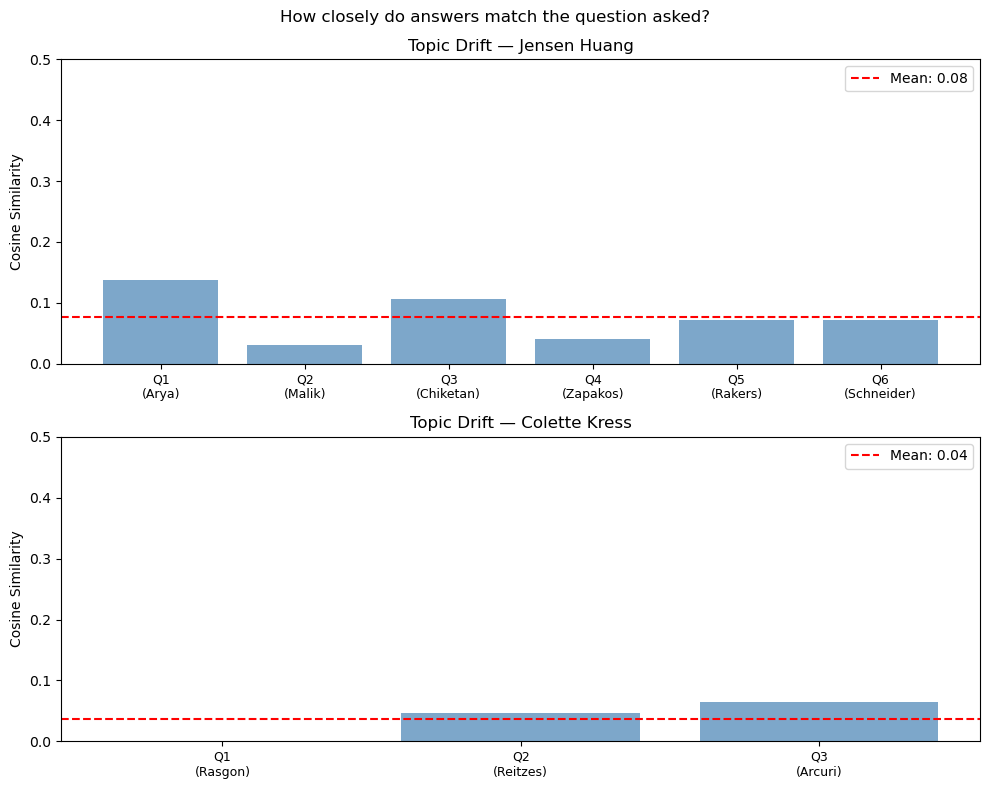

            analyst      responder  cosine_similarity
0        Vivek Arya   Jensen Huang              0.137
1      Stacy Rasgon  Colette Kress              0.000
2        Atif Malik   Jensen Huang              0.031
3       Ben Reitzes  Colette Kress              0.046
4  Antoine Chiketan   Jensen Huang              0.107
5      Mark Zapakos   Jensen Huang              0.040
6      Aaron Rakers   Jensen Huang              0.072
7        Tim Arcuri  Colette Kress              0.065
8     Jim Schneider   Jensen Huang              0.072


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

###### TOPIC DRIFT

# I am extracting Q&A turns only, drop operator/IR, as these are what I want to focus in future work too
qa_df = df[df["section"] == "Q&A"].copy().reset_index(drop=True)

# pairing each analyst question with the next management response 
pairs = []
for i, row in qa_df.iterrows():
    if row["role"] == "analyst":
        # looking for the next management turn after this question
        subsequent = qa_df.iloc[i+1:]
        mgmt_turns = subsequent[subsequent["role"] == "management"]
        if not mgmt_turns.empty:
            next_mgmt = mgmt_turns.iloc[0]
            pairs.append({
                "analyst": row["speaker"],
                "question": row["text"],
                "responder": next_mgmt["speaker"],
                "answer": next_mgmt["text"],
                "turn_id": row["turn_id"]
            })

pairs_df = pd.DataFrame(pairs)

# computing cosine similarity per pair

def compute_similarity(q, a):
    vec = TfidfVectorizer(stop_words="english")
    tfidf = vec.fit_transform([q, a])
    return cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]

pairs_df["cosine_similarity"] = pairs_df.apply(
    lambda r: compute_similarity(r["question"], r["answer"]), axis=1
)

# plotting separately for management people
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

for ax, speaker in zip(axes, ["Jensen Huang", "Colette Kress"]):
    subset = pairs_df[pairs_df["responder"] == speaker].reset_index(drop=True)
    if subset.empty:
        ax.set_title(f"{speaker} — no responses found")
        continue
    x = range(len(subset))
    bars = ax.bar(x, subset["cosine_similarity"], color="steelblue", alpha=0.7)
    ax.set_xticks(list(x))
    ax.set_xticklabels([f"Q{i+1}\n({row.analyst.split()[-1]})" 
                        for i, row in subset.iterrows()], fontsize=9)
    ax.axhline(subset["cosine_similarity"].mean(), color="red", 
               linestyle="--", label=f"Mean: {subset['cosine_similarity'].mean():.2f}")
    ax.set_ylabel("Cosine Similarity")
    ax.set_title(f"Topic Drift — {speaker}")
    ax.set_ylim(0, 0.5)
    ax.legend()

plt.suptitle("How closely do words match the question asked?", fontsize=12)
plt.tight_layout()
plt.show()

# the table

print(pairs_df[["analyst", "responder", "cosine_similarity"]].round(3).to_string())

#### Topic drift:

Do Jensen's answers actually stay on the topic of the question asked, or do they pivot? Measuring cosine similarity between question and answer embeddings

- Scores are universally low (all under 0.14). Both Jensen and Colette consistently drift away from the specific question asked.

- Jensen drifts more selectively. His highest score is Arya's CapEx question (0.137), which is directly in his wheelhouse. His lowest is Malik's CUDA question (0.031), where he pivoted to a broader infrastructure narrative.

- Colette drifts more severely, with a mean of 0.04 vs Jensen's 0.08. Rasgon's question scored 0.00, meaning her answer shared virtually no vocabulary with the question at all

- This aligns with a known pattern in earnings calls: Management uses analyst questions as launching pads for preferred narratives rather than giving direct answers, which is exactly the kind of signal my research proposal is trying to systematically capture

Important: One caveat worth noting: TF-IDF is a weak signal here, so it can only be a starting point for an exploratory walkdown. It only measures word overlap, not semantic meaning. Jensen could directly address a question using different vocabulary and still score low. This is precisely why transformer-based embeddings (like FinBERT) would be more reliable in the full study, and makes for a great point to raise in the interview.

Arya asks about CapEx, cloud customers, cash flow, growth. Jensen's answer also talks about compute, revenues, CapEx, cloud. There's meaningful word overlap, which leads to a higher score.

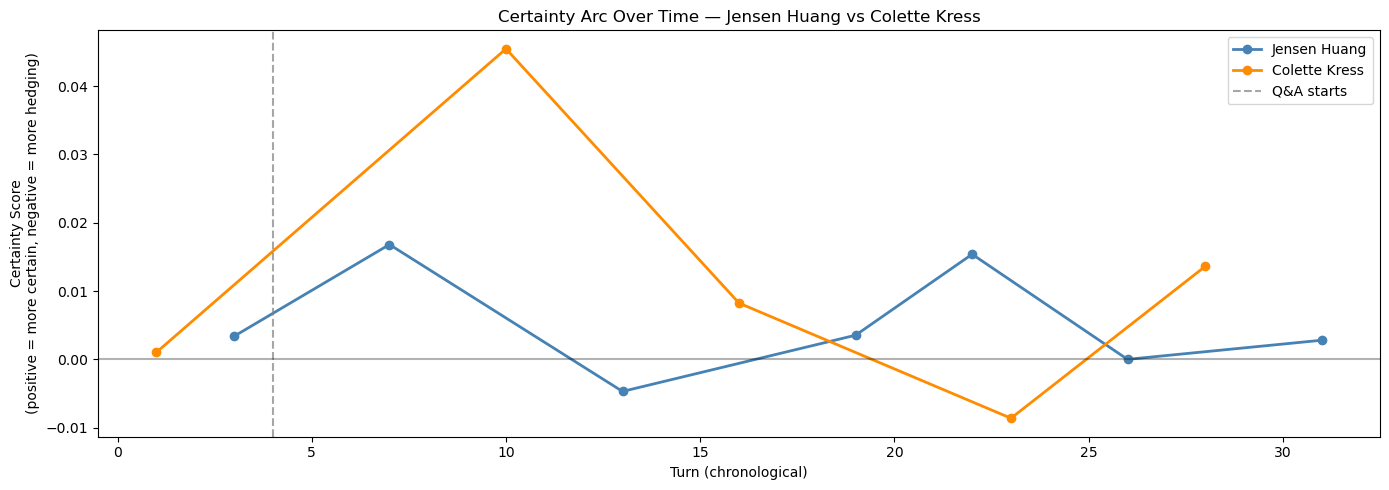

    turn_id        speaker           section  certainty_score
1         1  Colette Kress  Prepared Remarks           0.0010
3         3   Jensen Huang  Prepared Remarks           0.0034
7         7   Jensen Huang               Q&A           0.0168
10       10  Colette Kress               Q&A           0.0455
13       13   Jensen Huang               Q&A          -0.0047
16       16  Colette Kress               Q&A           0.0082
19       19   Jensen Huang               Q&A           0.0035
22       22   Jensen Huang               Q&A           0.0154
23       23  Colette Kress               Q&A          -0.0086
26       26   Jensen Huang               Q&A           0.0000
28       28  Colette Kress               Q&A           0.0136
31       31   Jensen Huang               Q&A           0.0028


In [22]:
#### CERTAINTY ARC OVER TIME

hedging_words = [
    "expect", "believe", "may", "could", "might", "approximately", "uncertain",
    "potentially", "possibly", "perhaps", "suggest", "likely", "unlikely",
    "assume", "hope", "estimate", "roughly", "around", "probably", "unclear"
]

booster_words = [
    "certain", "confident", "will", "definitely", "clearly", "absolutely",
    "sure", "committed", "unquestionably", "guarantee", "always", "undoubtedly",
    "strongly", "must", "know", "proven", "evident", "obvious"
]

def certainty_score(text):
    words = text.lower().split()
    n = len(words)
    if n == 0:
        return 0
    hedges = sum(1 for w in words if w in hedging_words)
    boosters = sum(1 for w in words if w in booster_words)
    return (boosters - hedges) / n

#  compuuting score for each turn
df["certainty_score"] = df["text"].apply(certainty_score)

# plot
fig, ax = plt.subplots(figsize=(14, 5))

colors = {"Jensen Huang": "steelblue", "Colette Kress": "darkorange"}

for speaker, color in colors.items():
    subset = df[df["speaker"] == speaker]
    ax.plot(subset["turn_id"], subset["certainty_score"], 
            marker="o", label=speaker, color=color, linewidth=2)

# marking section boundary
ax.axvline(x=qa_start, color="gray", linestyle="--", alpha=0.7, label="Q&A starts")
ax.axhline(y=0, color="black", linestyle="-", alpha=0.3)

ax.set_xlabel("Turn (chronological)")
ax.set_ylabel("Certainty Score\n(positive = more certain, negative = more hedging)")
ax.set_title("Certainty Arc Over Time — Jensen Huang vs Colette Kress")
ax.legend()
plt.tight_layout()
plt.show()

# scores per turn
print(df[df["role"] == "management"][["turn_id", "speaker", "section", "certainty_score"]].round(4).to_string())

#### Certainty Arc over time

- Both speakers start cautiously in prepared remarks, with scores close to zero, scripted language tends to be measured and balanced
Colette spikes sharply in early Q&A (turn 10, the gross margin question from Reitzes). She sounds most assertive when discussing financials, her home turf
Jensen dips below zero around turn 13 (Malik's CUDA question), his only moment of net hedging, suggesting genuine uncertainty or deliberate caution on that topic

- Colette also dips below zero later in Q&A (turn 23, the capital return question from Arcuri), the one topic where she hedges more than she asserts, which makes sense as it involves forward-looking financial commitments

- Jensen stays relatively flat and close to zero throughout, his language is consistently assertive but not dramatically so, suggesting a controlled, rehearsed confidence rather than spontaneous conviction

The broader signalis that Colette shows more volatility in certainty across topics, while Jensen maintains a steadier tone — consistent with their roles: she owns the numbers, he owns the vision.

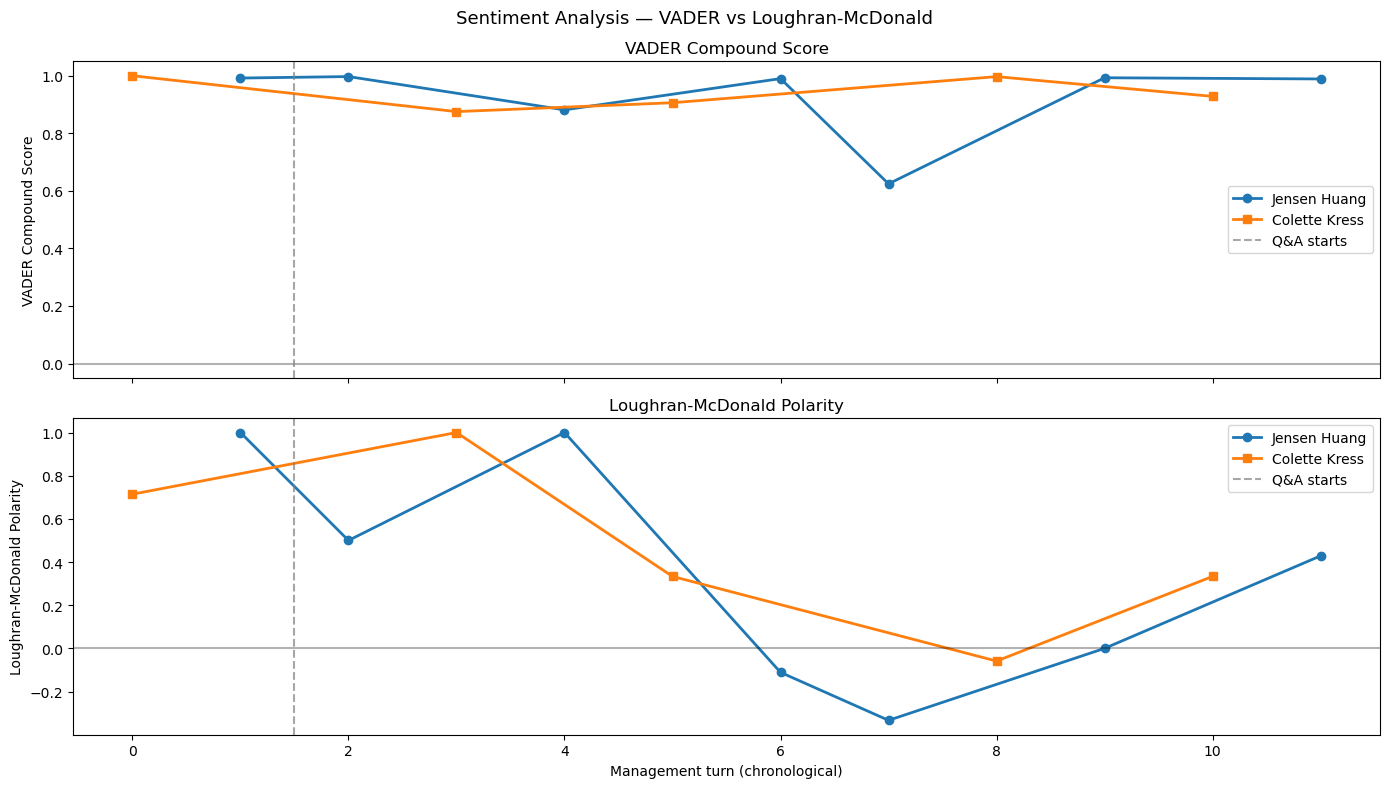

                                   vader_compound  lm_polarity
speaker          section                                      
Aaron Rakers     Q&A                        0.905       -1.000
Antoine Chiketan Q&A                        0.805       -1.000
Atif Malik       Q&A                        0.612       -1.000
Ben Reitzes      Q&A                        0.934        1.000
Colette Kress    Prepared Remarks           0.999        0.714
                 Q&A                        0.926        0.402
Jensen Huang     Prepared Remarks           0.991        1.000
                 Q&A                        0.912        0.247
Jim Schneider    Q&A                        0.820       -1.000
Mark Zapakos     Q&A                        0.722       -1.000
Sarah            Q&A                        0.246       -0.818
Stacy Rasgon     Q&A                        0.440       -1.000
Tim Arcuri       Q&A                        0.988        0.000
Toshiya Hari     Prepared Remarks           0.363      

In [25]:
# Sentiment Analysis — VADER + Loughran-McDonald

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pysentiment2 as ps

# VADER sentiment 
vader = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = vader.polarity_scores(text)
    return pd.Series({
        "vader_pos": scores["pos"],
        "vader_neg": scores["neg"],
        "vader_neu": scores["neu"],
        "vader_compound": scores["compound"]
    })

vader_scores = df["text"].apply(vader_sentiment)
df = pd.concat([df, vader_scores], axis=1)

# Loughran-McDonald sentiment 
lm = ps.LM()

def lm_sentiment(text):
    tokens = lm.tokenize(text)
    score = lm.get_score(tokens)
    return pd.Series({
        "lm_pos": score["Positive"],
        "lm_neg": score["Negative"],
        "lm_polarity": score["Polarity"]  # (pos - neg) / (pos + neg)
    })

lm_scores = df["text"].apply(lm_sentiment)
df = pd.concat([df, lm_scores], axis=1)

# plot: VADER vs LM compound score for management turns
mgmt_df = df[df["role"] == "management"].copy().reset_index(drop=True)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

for ax, (score_col, label, color) in zip(axes, [
    ("vader_compound", "VADER Compound Score", "steelblue"),
    ("lm_polarity",    "Loughran-McDonald Polarity", "darkorange")
]):
    for speaker, marker in [("Jensen Huang", "o"), ("Colette Kress", "s")]:
        subset = mgmt_df[mgmt_df["speaker"] == speaker]
        ax.plot(subset.index, subset[score_col], marker=marker,
                label=speaker, linewidth=2)
    ax.axhline(0, color="black", linestyle="-", alpha=0.3)
    ax.axvline(
        mgmt_df[mgmt_df["section"] == "Q&A"].index[0] - 0.5,
        color="gray", linestyle="--", alpha=0.7, label="Q&A starts"
    )
    ax.set_ylabel(label)
    ax.legend()
    ax.set_title(label)

axes[-1].set_xlabel("Management turn (chronological)")
plt.suptitle("Sentiment Analysis — VADER vs Loughran-McDonald", fontsize=13)
plt.tight_layout()
plt.show()

# summary table
print(df.groupby(["speaker", "section"])[["vader_compound", "lm_polarity"]].mean().round(3))

#### VADER and LOUGHRAN-MCDONALD plots for sentiment analysis

VADER: Almost everything is positive and clustered near 1.0. However, VADER is too generic for financial text. It reads earnings call language as overwhelmingly positive because it wasn't built for finance. This is exactly why Loughran-McDonald exists.


Loughran-McDonald: It is a much more informative plot. Both Jensen and Colette start strongly positive in prepared remarks but decline notably through Q&A, with Jensen hitting negative territory mid-call. This suggests that scripted remarks are deliberately optimistic, while unscripted responses reveal more cautious or financially loaded language.

Note: It's useful to know that LM polarity scores of exactly +-1.0 for analysts are unreliable artifacts of their short turns containing only one financial word, not genuine sentiment signals.

These plots directly validate one of the core arguments in my research proposal, which argues generic sentiment tools miss domain-specific nuance, and finance-specific lexicons are necessary.

### Adding linguistic complexity

- Flesch Reading Ease scores how easy a text is to read based on sentence length and syllable count, where lower scores mean more complex, harder-to-read language. 

- Flesch-Kincaid Grade Level converts that same formula into a US school grade equivalent, so a score of 12 means the text requires a 12th-grade reading level.

Note: Average sentence length and syllables per word are the raw building blocks underneath both formulas, as longer sentences and more polysyllabic words directly drive complexity upward.

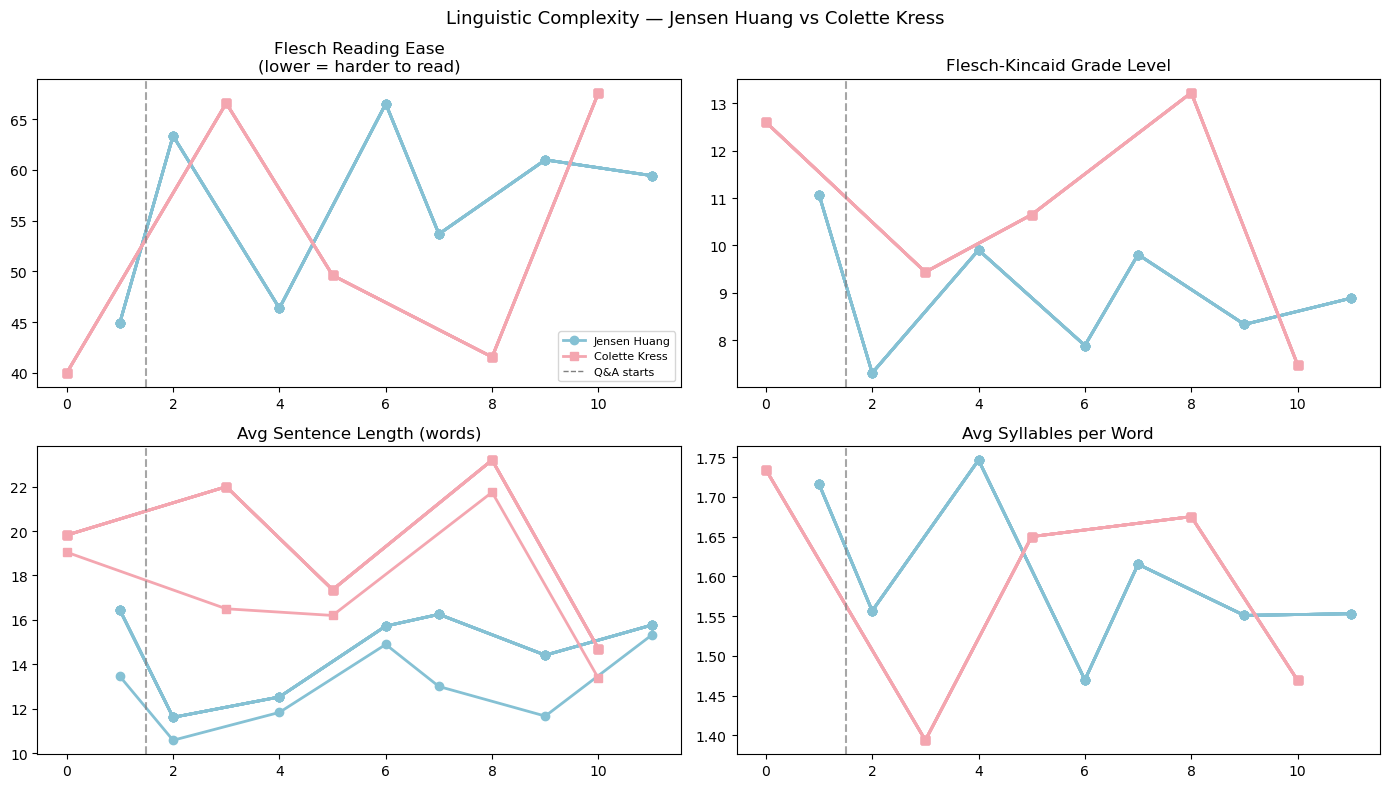

                                flesch_reading_ease  flesch_reading_ease  \
speaker       section                                                      
Colette Kress Prepared Remarks                39.98                39.98   
              Q&A                             56.34                56.34   
Jensen Huang  Prepared Remarks                44.95                44.95   
              Q&A                             58.39                58.39   

                                flesch_reading_ease  flesch_reading_ease  \
speaker       section                                                      
Colette Kress Prepared Remarks                39.98                39.98   
              Q&A                             56.34                56.34   
Jensen Huang  Prepared Remarks                44.95                44.95   
              Q&A                             58.39                58.39   

                                flesch_reading_ease  flesch_reading_ease  \
speaker   

In [35]:
# ── Step 5: Linguistic Complexity ─────────────────────────────────────────────

import textstat
from matplotlib.lines import Line2D

def complexity_metrics(text):
    return pd.Series({
        "flesch_reading_ease":    textstat.flesch_reading_ease(text),
        "flesch_kincaid_grade":   textstat.flesch_kincaid_grade(text),
        "avg_sentence_length":    textstat.words_per_sentence(text),
        "avg_syllables_per_word": textstat.avg_syllables_per_word(text),
        "difficult_words":        textstat.difficult_words(text)
    })

complexity = df["text"].apply(complexity_metrics)
df = pd.concat([df, complexity], axis=1)

# ── Plot: complexity for management turns ─────────────────────────────────────
mgmt_df = df[df["role"] == "management"].copy().reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

metrics = [
    ("flesch_reading_ease",    "Flesch Reading Ease\n(lower = harder to read)"),
    ("flesch_kincaid_grade",   "Flesch-Kincaid Grade Level"),
    ("avg_sentence_length",    "Avg Sentence Length (words)"),
    ("avg_syllables_per_word", "Avg Syllables per Word"),
]

colors = {"Jensen Huang": "#85C1D4", "Colette Kress": "#F4A6B0"}

for ax, (col, title) in zip(axes.flatten(), metrics):
    for speaker, marker in [("Jensen Huang", "o"), ("Colette Kress", "s")]:
        subset = mgmt_df[mgmt_df["speaker"] == speaker]
        ax.plot(subset.index, subset[col], marker=marker,
                linewidth=2, color=colors[speaker])
    ax.axvline(
        mgmt_df[mgmt_df["section"] == "Q&A"].index[0] - 0.5,
        color="gray", linestyle="--", alpha=0.7
    )
    ax.set_title(title)

# ── Manual legend ─────────────────────────────────────────────────────────────
legend_elements = [
    Line2D([0], [0], color="#85C1D4", marker="o", linewidth=2, label="Jensen Huang"),
    Line2D([0], [0], color="#F4A6B0", marker="s", linewidth=2, label="Colette Kress"),
    Line2D([0], [0], color="gray", linestyle="--", linewidth=1, label="Q&A starts"),
]
axes.flatten()[0].legend(handles=legend_elements, fontsize=8)

plt.suptitle("Linguistic Complexity — Jensen Huang vs Colette Kress", fontsize=13)
plt.tight_layout()
plt.show()

# ── Summary table ─────────────────────────────────────────────────────────────
print(df[df["role"] == "management"].groupby(["speaker", "section"])[
    ["flesch_reading_ease", "flesch_kincaid_grade", "avg_sentence_length"]
].mean().round(2))

#### Key takeaways

- Colette consistently uses longer sentences and higher grade-level language than Jensen, particularly in prepared remarks, confirming that her role demands denser, more technical financial communication. 

- Both speakers simplify noticeably when entering Q&A, which suggests that unscripted dialogue naturally reduces linguistic complexity regardless of speaker. 

- For my broader study, this is a meaningful signal. complexity dropping in Q&A could indicate either genuine conversational adaptation or a deliberate strategy to appear more accessible and confident under analyst scrutiny, and distinguishing between the two across many earnings calls would be a valuable research contribution.